In [221]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from catboost import CatBoostClassifier
from catboost import Pool
from imblearn.over_sampling import SMOTE
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import f_classif

In [222]:
# Reading the data
df = pd.read_csv("./data.csv")

In [223]:
X_init = df.drop(['id', 'target'], axis=1)
y_init = df['target']

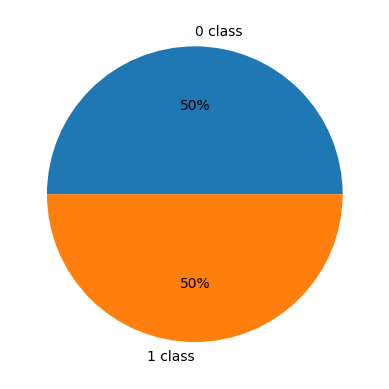

In [224]:
# Target class oversampling, fixing target class imbalance
smote = SMOTE()
X, y = smote.fit_resample(X_init, y_init)

# Visualization of data after minor class oversampling
data = y.value_counts()
labels = ['0 class', '1 class']

plt.pie(data, labels=labels, autopct='%.0f%%')
plt.show()

In [225]:
# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [226]:
# Feature selection using Anova-F
def select_features(X_train, y_train):
	fs = SelectKBest(score_func=f_classif, k='all')
	fs.fit(X_train, y_train)
	return fs


fs = select_features(X, y)

# List of chosen features
features = []

# Feature Scores
for i in range(len(fs.scores_)):
	if fs.scores_[i] > 13:
		features.append(df.columns[i])
	print('Feature %d: %f' % (i, fs.scores_[i]))

# Applying chosen features on our dataset
# P.S.: Results may differ from time to time
# It's a good idea to use this feature selection with the EDA I've made
# and manually choose features so to have more stable results
# Tho for the sake of 'saving my time' I'll leave this as it is
X_train = X_train[features]
X_test = X_test[features]
X_init = X_init[features]
X = X[features]

features

Feature 0: 6.786788
Feature 1: 7.278122
Feature 2: 11.817403
Feature 3: 1.647529
Feature 4: 16.461718
Feature 5: 14.485837
Feature 6: 3.722650
Feature 7: 3.359828
Feature 8: 12.407254
Feature 9: 0.302775
Feature 10: 2.900658
Feature 11: 13.305720
Feature 12: 4.988620
Feature 13: 0.045877
Feature 14: 0.867613
Feature 15: 7.390098
Feature 16: 0.000968
Feature 17: 2.747737
Feature 18: 4.685264
Feature 19: 1.677628
Feature 20: 1.298438
Feature 21: 4.194194
Feature 22: 0.501763
Feature 23: 13.409825
Feature 24: 6.169425
Feature 25: 1.516952
Feature 26: 1.004998
Feature 27: 2.965879
Feature 28: 5.181863
Feature 29: 9.062271
Feature 30: 0.089174
Feature 31: 0.232850
Feature 32: 0.935761
Feature 33: 0.406670
Feature 34: 1.545663
Feature 35: 2.377701
Feature 36: 0.232152
Feature 37: 13.691804
Feature 38: 2.012148
Feature 39: 5.315086
Feature 40: 25.316491
Feature 41: 4.685369
Feature 42: 0.356396
Feature 43: 0.104255
Feature 44: 0.019914
Feature 45: 0.538881
Feature 46: 12.847964
Feature 47: 0.

['var_2',
 'var_3',
 'var_9',
 'var_21',
 'var_35',
 'var_38',
 'var_68',
 'var_138',
 'var_141']

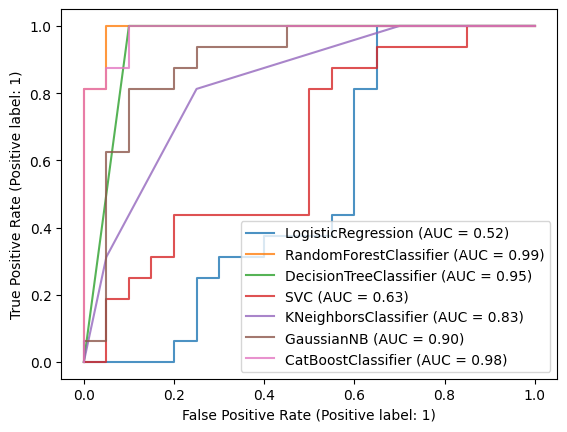

In [227]:
# Instances of different classification models
# Also fitting them here for futher roc-auc comparison
lr = LogisticRegression()
lr.fit(X_train, y_train)
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
svc = SVC()
svc.fit(X_train, y_train)
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
gnb = GaussianNB()
gnb.fit(X_train, y_train)
cb = CatBoostClassifier(silent=True)
cb.fit(X_train, y_train)

# Visualizing models performance using roc-auc graph
# Roc-auc was chosen since we have a binary classification problem
# Also it's really helpful in understanding which model performs better
# + I've balanced the dataset, so everything should be fine
# P.S.: Seems like catboost and random forest win almost every time, I'll choose catboost
ax = plt.gca()
lr_disp = RocCurveDisplay.from_estimator(lr, X_test, y_test, ax=ax, alpha=0.8)
rf_disp = RocCurveDisplay.from_estimator(rf, X_test, y_test, ax=ax, alpha=0.8)
dt_disp = RocCurveDisplay.from_estimator(dt, X_test, y_test, ax=ax, alpha=0.8)
svc_disp = RocCurveDisplay.from_estimator(svc, X_test, y_test, ax=ax, alpha=0.8)
knn_disp = RocCurveDisplay.from_estimator(knn, X_test, y_test, ax=ax, alpha=0.8)
gnb_disp = RocCurveDisplay.from_estimator(gnb, X_test, y_test, ax=ax, alpha=0.8)
cb_disp = RocCurveDisplay.from_estimator(cb, X_test, y_test, ax=ax, alpha=0.8)
plt.show()

In [228]:
# CatBoostClassifier Parameters
learning_rate = [x for x in np.linspace(0.001, 0.01, 50)]
depth = [x for x in np.linspace(4, 10, 7)]
l2_leaf_reg = [x for x in np.linspace(2, 10, 9)]
random_strength = [x for x in np.linspace(0, 10, 11)]

# Random Grid for Randomized Search
random_grid = {'learning_rate': learning_rate,
    'depth': depth,
    'l2_leaf_reg': l2_leaf_reg,
    'random_strength': random_strength
}

# Instance of the RandomizedSearchCV
cb_random = RandomizedSearchCV(estimator = cb,
    param_distributions = random_grid,
    n_iter = 100,
    cv = 3,
    verbose=0,
    random_state=42,
    n_jobs = -1)

# Fitting the RSCV
cb_random.fit(X, y)

# Output Parameters
cb_params = cb_random.best_params_

# Catboost model with it's chosen parameters
# P.S.: Catboost works awesome straight out of the box
# Imo hyperparameters are still useful here
model = CatBoostClassifier(random_strength=cb_params['random_strength'],
    learning_rate=cb_params['learning_rate'],
    l2_leaf_reg=cb_params['l2_leaf_reg'],
    depth=cb_params['depth'],
    silent=True)

train_pool = Pool(data=X_train,label = y_train)

model.fit(train_pool, plot=True, silent=True)
print(model.get_best_score())

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

{'learn': {'Logloss': 0.06916953495570592}}


In [229]:
# Model roc-auc evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
ra_scores = cross_val_score(model, X_test, y_test, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC:', np.mean(ra_scores), '| Standart Deviation:', np.std(ra_scores))

Mean ROC AUC: 0.85 | Standart Deviation: 0.3068658773253662


In [230]:
# Results
predictions = model.predict(X_init)
pred_df = pd.DataFrame()
pred_df['prediction'] = predictions
pred_df.to_csv('predictions.csv',index=False)